In [231]:
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import pandas as pd
import pickle
import os
from tensorflow.keras.models import load_model
from sklearn.model_selection import LeaveOneGroupOut
from sklearn.metrics import confusion_matrix, classification_report

In [252]:
# load all models by fold

model_dict = {}

for i in range(1,11):
    model_dict[i] = load_model('models/mels_2/mels_basic_cnn_fold{}.hdf5'.format(i))

In [253]:
labels = np.array(['dog_bark', 'children_playing', 'children_playing', ...,
       'car_horn', 'car_horn', 'car_horn'], dtype='<U16')

In [254]:
#load data for splitting by test

vec_type = 'mels'
data_path = os.path.join('pickles', 'urbansound_'+ vec_type + '.p')

with open(data_path, 'rb') as handle:
    data = pickle.load(handle)

X, y, folds = data[0], data[1], data[2]

X = X.reshape(X.shape[0], 60, 174, 1)

In [255]:
# build dataframe to store predictions for each fold, for each sample 
# not all samples will have fold
metadata = pd.read_csv('UrbanSound8K/metadata/UrbanSound8K.csv')

In [297]:
meta = metadata.drop(columns=['fsID', 'start', 'end', 'salience'])
meta

,slice_file_name,fold,classID,class
0,100032-3-0-0.wav,5,3,dog_bark
1,100263-2-0-117.wav,5,2,children_playing
2,100263-2-0-121.wav,5,2,children_playing
3,100263-2-0-126.wav,5,2,children_playing
4,100263-2-0-137.wav,5,2,children_playing
...,...,...,...,...
8727,99812-1-2-0.wav,7,1,car_horn
8728,99812-1-3-0.wav,7,1,car_horn
8729,99812-1-4-0.wav,7,1,car_horn
8730,99812-1-5-0.wav,7,1,car_horn


Important Note: classID relates to how 'y' was encoded

In [257]:
meta.classID.unique()

array([3, 2, 1, 0, 9, 6, 8, 5, 7, 4])

In [258]:
y_df = pd.DataFrame(y)
y_df

,0,1,2,3,4,5,6,7,8,9
0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...
8727,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
8728,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
8729,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
8730,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [259]:
all_preds = np.zeros((8732, 10))

In [260]:
logo = LeaveOneGroupOut()
#recreate fold indices used to train and test models. Use preds on test set 



for train_idx, test_idx in logo.split(X, y, folds):
    
    _, X_test, _, y_test = X[train_idx], X[test_idx], y[train_idx], y[test_idx]
    fold = folds[test_idx][0]
    
    #load model
    model = model_dict[fold]
    
    
    #make preds
    #each sample should have a 10 dimensional pred
    fold_pred = model.predict_proba(X_test)
    print('fold pred shape: ', fold_pred.shape)
    
    #stack preds on earlier samples
    all_preds[test_idx, :] = fold_pred
#     print("samples_preds shape: ", samples_preds.shape)
    


fold pred shape:  (873, 10)
fold pred shape:  (888, 10)
fold pred shape:  (925, 10)
fold pred shape:  (990, 10)
fold pred shape:  (936, 10)
fold pred shape:  (823, 10)
fold pred shape:  (838, 10)
fold pred shape:  (806, 10)
fold pred shape:  (816, 10)
fold pred shape:  (837, 10)


In [272]:
all_preds

array([[1.45e-09, 9.67e-02, 6.37e-05, ..., 7.86e-08, 1.61e-04, 3.25e-06],
       [1.44e-01, 5.83e-02, 1.37e-01, ..., 1.08e-01, 1.49e-01, 9.74e-02],
       [1.19e-01, 4.48e-02, 2.03e-01, ..., 8.63e-02, 1.80e-01, 9.26e-02],
       ...,
       [2.14e-02, 2.39e-01, 1.81e-01, ..., 1.59e-02, 4.52e-02, 2.35e-01],
       [3.33e-03, 1.96e-01, 2.42e-01, ..., 3.54e-02, 1.19e-01, 1.68e-02],
       [3.12e-02, 2.55e-01, 1.10e-01, ..., 4.23e-02, 2.82e-01, 6.46e-02]])

In [261]:
pred_classes = np.argmax(all_preds, axis=1)
pred_classes.shape

(8732,)

In [298]:
meta['predID'] = pred_classes
meta

,slice_file_name,fold,classID,class,predID
0,100032-3-0-0.wav,5,3,dog_bark,3
1,100263-2-0-117.wav,5,2,children_playing,8
2,100263-2-0-121.wav,5,2,children_playing,2
3,100263-2-0-126.wav,5,2,children_playing,2
4,100263-2-0-137.wav,5,2,children_playing,2
...,...,...,...,...,...
8727,99812-1-2-0.wav,7,1,car_horn,2
8728,99812-1-3-0.wav,7,1,car_horn,1
8729,99812-1-4-0.wav,7,1,car_horn,1
8730,99812-1-5-0.wav,7,1,car_horn,2


In [274]:
target_names = []
id2name = {}
for i in range(10):
    name = meta[meta['classID'] == i]['class'].iloc[0]
    target_names.append(name)
    id2name[i] = name
print(target_names)

['air_conditioner', 'car_horn', 'children_playing', 'dog_bark', 'drilling', 'engine_idling', 'gun_shot', 'jackhammer', 'siren', 'street_music']


In [275]:
id2name

{0: 'air_conditioner',
 1: 'car_horn',
 2: 'children_playing',
 3: 'dog_bark',
 4: 'drilling',
 5: 'engine_idling',
 6: 'gun_shot',
 7: 'jackhammer',
 8: 'siren',
 9: 'street_music'}

In [303]:
meta['pred_class'] = meta['predID'].map(id2name)
meta

,slice_file_name,fold,classID,class,predID,pred_class
0,100032-3-0-0.wav,5,3,dog_bark,3,dog_bark
1,100263-2-0-117.wav,5,2,children_playing,8,siren
2,100263-2-0-121.wav,5,2,children_playing,2,children_playing
3,100263-2-0-126.wav,5,2,children_playing,2,children_playing
4,100263-2-0-137.wav,5,2,children_playing,2,children_playing
...,...,...,...,...,...,...
8727,99812-1-2-0.wav,7,1,car_horn,2,children_playing
8728,99812-1-3-0.wav,7,1,car_horn,1,car_horn
8729,99812-1-4-0.wav,7,1,car_horn,1,car_horn
8730,99812-1-5-0.wav,7,1,car_horn,2,children_playing


In [286]:
def plot_confusion_matrix(cm, title='Confusion matrix', cmap=plt.cm.Blues):
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title, fontweight='bold')
    plt.colorbar(fraction=.045)
    tick_marks = np.arange(len(target_names))
    plt.xticks(tick_marks, target_names, rotation=45)
    plt.yticks(tick_marks, target_names)
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')


In [299]:
cm =confusion_matrix(meta.classID, meta.predID)
# np.set_printoptions(precision=2)
# print('Confusion matrix, without normalization')
# print(cm)
# plt.figure(figsize=(10, 10))
# plot_confusion_matrix(cm)


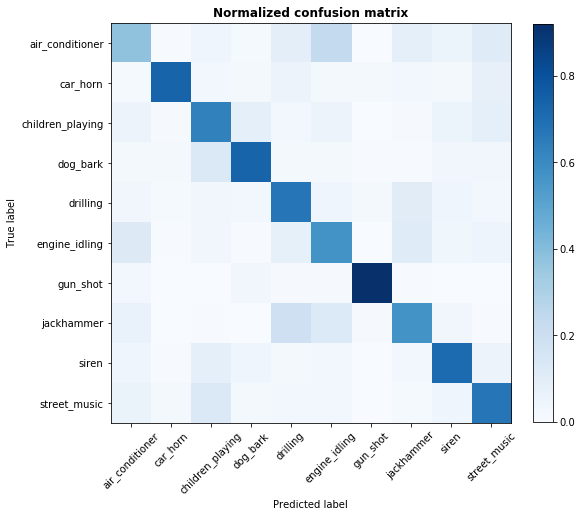

In [338]:
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
# print('Normalized confusion matrix')
# print(cm_normalized)
plt.figure(figsize=(8,8))
plot_confusion_matrix(cm_normalized, title='Normalized confusion matrix', cmap='Blues')
plt.savefig('img/confmat_1.png', bbox_inches='tight', dpi=256)

In [339]:
print(classification_report(meta['class'], meta['pred_class']))

                  precision    recall  f1-score   support

 air_conditioner       0.49      0.38      0.43      1000
        car_horn       0.82      0.73      0.78       429
children_playing       0.58      0.63      0.61      1000
        dog_bark       0.78      0.73      0.76      1000
        drilling       0.59      0.67      0.63      1000
   engine_idling       0.51      0.57      0.54      1000
        gun_shot       0.89      0.92      0.91       374
      jackhammer       0.62      0.57      0.59      1000
           siren       0.70      0.71      0.71       929
    street_music       0.64      0.67      0.66      1000

        accuracy                           0.64      8732
       macro avg       0.66      0.66      0.66      8732
    weighted avg       0.64      0.64      0.63      8732



In [251]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 60, 174, 16)       160       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 30, 87, 16)        0         
_________________________________________________________________
dropout (Dropout)            (None, 30, 87, 16)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 30, 87, 32)        2080      
_________________________________________________________________
dropout_1 (Dropout)          (None, 30, 87, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 30, 87, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 15, 43, 64)        0

In [346]:
### loading 'best' model

In [350]:
model = load_model('models/froms3_mels_basic_cnn_fold1.hdf5')

In [351]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_3 (Conv2D)            (None, 59, 173, 16)       80        
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 29, 86, 16)        0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 28, 85, 32)        2080      
_________________________________________________________________
dropout_3 (Dropout)          (None, 28, 85, 32)        0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 26, 83, 64)        18496     
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 13, 41, 64)        0         
_________________________________________________________________
dropout_4 (Dropout)          (None, 13, 41, 64)       

In [352]:
model.get_config()

{'name': 'sequential_1',
 'layers': [{'class_name': 'Conv2D',
   'config': {'name': 'conv2d_3',
    'trainable': True,
    'batch_input_shape': (None, 60, 174, 1),
    'dtype': 'float32',
    'filters': 16,
    'kernel_size': (2, 2),
    'strides': (1, 1),
    'padding': 'valid',
    'data_format': 'channels_last',
    'dilation_rate': (1, 1),
    'activation': 'relu',
    'use_bias': True,
    'kernel_initializer': {'class_name': 'GlorotUniform',
     'config': {'seed': None}},
    'bias_initializer': {'class_name': 'Zeros', 'config': {}},
    'kernel_regularizer': {'class_name': 'L1L2',
     'config': {'l1': 0.0, 'l2': 9.999999747378752e-05}},
    'bias_regularizer': None,
    'activity_regularizer': None,
    'kernel_constraint': None,
    'bias_constraint': None}},
  {'class_name': 'MaxPooling2D',
   'config': {'name': 'max_pooling2d_2',
    'trainable': True,
    'dtype': 'float32',
    'pool_size': (2, 2),
    'padding': 'valid',
    'strides': (2, 2),
    'data_format': 'channel